# Decision Trees

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as nplin
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import decisionTree as dt
import time as t

**Generating Toy Data**: we will generate data in a checkerboard pattern with two columns and three rows of alternating green and red data point clusters. This will allow us to see how the DT performs its splits.

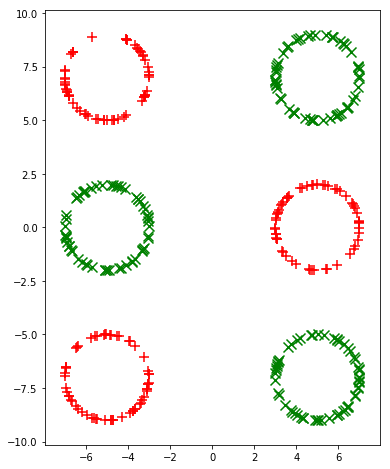

In [3]:
d = 2 
n = 60
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [-5, 7], r )
XPos = np.vstack( (tmp1, tmp2, tmp3) )
yPos = np.ones( (3*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [-5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [5, 7], r )
XNeg = np.vstack( (tmp1, tmp2, tmp3) )
yNeg = -np.ones( (3*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

fig1 = pd.getFigure(6,8)
pd.plot2D( XPos, fig1, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig1, color = 'g', marker = 'x' )

**Purity of a Node**: let us use the Gini index (aka Gini coefficient) to measure the purity of a node. The Gini coefficient was original developed by economists to measure wealth inequality. The Gini index is always a real number between 0 and 0.5. A perfectly pure node has Gini index = 0 whereas the most polluted node (half the points are of each color in a binary setting) will have a Gini index of 0.5. The smaller the Gini index of a node, the purer the node. Entropy is another popular metric to decide purity of a node.

In [4]:
# Get the Gini coefficient of a node with nPos positive points and nNeg negative points
def getGini( nPos, nNeg ):
    nTot = nPos + nNeg
    # Find the proportion of the positives and negatives in that node
    pPos = nPos/nTot
    pNeg = nNeg/nTot
    gini = 1 - (pPos**2 + pNeg**2)
    return gini

**Balance of a Split**: there are several ways of finding the balance of a split. We will use a simple technique of max - min over min that always gives us a positive number that we will call the _balance factor_. The smaller the balance factor the more balanced the split. A perfectly balanced split will have balance factor = 0 whereas the most imbalanced split (one node is empty and the other has all the points) will have an infinite balance factor. There are several other possible notions of balance as well such as entropy (i.e. entropy can be used to measure purity as well as balance).

In [5]:
# Get the balance factor of a certain split that sends nLeft and nRight data points to left and right child
def getBalance( nLeft, nRight ):
    balance = max(nLeft, nRight)/min(nLeft, nRight) - 1
    return balance

**Creating a Decision Stump**: let us now create a decision stump that will splilt nodes of our decision tree into (hopefully) purer nodes in a balanced manner. Our stump will consider the balance (as indicated by balance factor) and purity (as indicated by Gini index) while making its decision. We can assign differing weightages to these two factors e.g. give balance more weightage if we cannot tolerate an unbalanced tree or else give purity more weightage if we wish very good training accuracy.

In [6]:
def getBalancedGiniStump( X, y, ancestorSplitFeats ):
    # How many data points do I have at this node?
    n = y.size
    bestObjective = float('inf')

    # For each of the features in the data
    for i in range( X.shape[1] ):
        # Do not use the same feature as used by the parent node
        if ancestorSplitFeats.size > 0 and i == ancestorSplitFeats[-1]:
            continue
        # Find out all values at which we can threshold that feature
        candidateThresholds = np.sort( X[:, i] )
        idx = np.argsort( X[:, i] )
        # The cumulative sum trick used here will work only if labels are binary :)
        ySorted = y[idx]
        yCum = np.cumsum( ySorted )
        yCumRev = np.cumsum( ySorted[::-1] )[::-1]
        # For each possible threshold (except the ones at the extreme)
        for j in range( 1, candidateThresholds.size-1 ):
            # Give 0.5 weight to balance and 1 weight to purity of the two nodes
            candidateObjective = wBalance * getBalance( j+1, n-j-1 ) \
                                + wPurity * getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
                                + wPurity * getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )
            if candidateObjective < bestObjective:
                bestObjective = candidateObjective
                bestFeat = i
                bestThresh = candidateThresholds[j]
                
    return (bestFeat, bestThresh)

# How much importance we wish to assign to balance vs purity is a hyperparameter
# We may either fix this using our domain knowledge or else tune it via validation
wBalance = 0.5
wPurity = 1.0

**Training our DT**: now that we have prepared our custom decision stump, training the tree is straightforward using the library function call. You would notice that the split boundaries of this DT pass very close to training points. Can you give a reason why this is happening? This is actually not a good thing to happen since this means that the decision boundary of this DT passes very close to training points. Since decision boundaries are regions where the classifer is unsure and rapidly changes its decision, this is not a good sign.

You may want to first set maxDepth = 1 then maxDepth = 2 and so on to see how the DT repeatedly splits cells to produce its partitions.

It took 0.015625 seconds to complete training the DT
It took 0.953125 seconds to complete testing with a DT


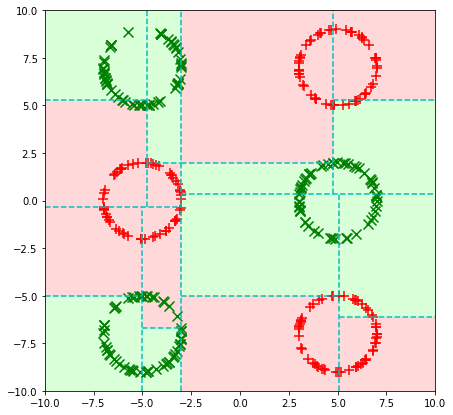

In [7]:
maxLeafSize = 5
maxDepth = 4

dtGini = dt.Tree( maxLeafSize, maxDepth )
tic = t.process_time()
dtGini.train( X, y, getBalancedGiniStump )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete training the DT")

fig2 = pd.getFigure()
tic = t.process_time()
pd.shade2D( dtGini.predict, fig2, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete testing with a DT")
dtGini.drawTreeSplits( fig2, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig2, color = 'r', marker = '+' )
pd.plot2D( XPos, fig2, color = 'g', marker = 'x' )

**A Faster Decision Stump**: let us try out a variant that uses the LwP techique to decide the best threshold along a chosen feature. This would be much faster than trying out all possible thresholds by running a for loop. You would notice that the LwP decision stumps also produce splits that are far more pleasing in that they do not venture too close to any training point. This is very beneficial since this means that the decision boundaries of the LwP DT passes through empty space where we do not have training points.

It took 0.00000 seconds to complete training the LwP-based DT
It took 1.03125 seconds to complete testing with a LwP-based DT


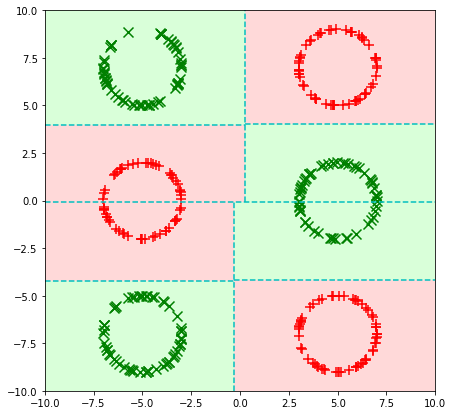

In [8]:
# Create a stump using the LwP algorithm to decide thresholds
def getLwPStump( X, y, ancestorSplitFeats ):
    n = y.size
    bestObjective = float('inf')

    # For each of the features in the data
    for i in range( X.shape[1] ):
        # Do not use the same feature as used by the parent node
        if ancestorSplitFeats.size > 0 and i == ancestorSplitFeats[-1]:
            continue
        thresh = (np.mean( X[y > 0, i] ) + np.mean( X[y < 0, i] ))/2
        nLeftPos = np.sum( y[np.logical_and( y > 0, X[:, i] <= thresh )] )
        nLeftNeg = np.sum( y[np.logical_and( y < 0, X[:, i] <= thresh )] )
        nRightPos = np.sum( y[np.logical_and( y > 0, X[:, i] > thresh )] )
        nRightNeg = np.sum( y[np.logical_and( y < 0, X[:, i] > thresh )] )
        candidateObjective = wBalance * getBalance( nLeftPos + nLeftNeg, nRightPos + nRightNeg ) \
                                + wPurity * getGini( nLeftPos, nLeftNeg ) \
                                + wPurity * getGini( nRightPos, nRightNeg )
        if candidateObjective < bestObjective:
            bestObjective = candidateObjective
            bestFeat = i
            bestThresh = thresh
            
    return (bestFeat, bestThresh)

maxLeafSize = 5
maxDepth = 3

dtLwP = dt.Tree( maxLeafSize, maxDepth )
tic = t.process_time()
dtLwP.train( X, y, getLwPStump )
toc = t.process_time()
print( "It took %1.5f seconds to complete training the LwP-based DT" % (toc - tic) )

fig3 = pd.getFigure()
tic = t.process_time()
pd.shade2D( dtLwP.predict, fig3, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete testing with a LwP-based DT")
dtLwP.drawTreeSplits( fig3, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig3, color = 'r', marker = '+' )
pd.plot2D( XPos, fig3, color = 'g', marker = 'x' )

**Comparing DT with kNN**: DTs give predictions much faster compared to kNN as the number of training points increases. You may see this in a much more pronounced manner by setting n = 500. Be prepared to wait for a bit longer for NN to do its job if you do this though :) In practice, kNN search is sped up using various data structures like kd-trees, BBD trees HNSW and algorithms like random projections and locality sensitive hashing.

It took 12.65625 seconds to complete testing with kNN


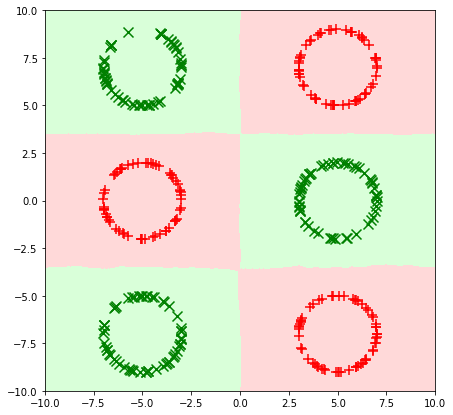

In [9]:
def kNNClass( xt, yt ):
    diff = X - np.array( [xt, yt] )
    dist = nplin.norm( diff, axis = 1 )
    idx = np.argsort( dist )
    yhat = 0
    wsum = 0
    for i in range( k ):
        yhat = yhat + y[idx[i]]
    return yhat/k

k = 5
fig4 = pd.getFigure()
tic = t.process_time()
pd.shade2D( kNNClass, fig4, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete testing with kNN")
pd.plot2D( XNeg, fig4, color = 'r', marker = '+' )
pd.plot2D( XPos, fig4, color = 'g', marker = 'x' )